# Demonstration of Masks and Filters
You'll learn how to exploit intensity patterns to select sub-regions of an array, and you'll use convolutional filters to detect interesting features. 

This demo is a jupyter notebook, i.e. intended to be run step by step.

Author: Eric Einspänner
<br>
Contributor: Nastaran Takmilhomayouni

First version: 6th of July 2023


Copyright 2023 Clinic of Neuroradiology, Magdeburg, Germany

License: Apache-2.0

## Table of contents
1. [Initial set-up](#Initial-Set-Up)
2. [Load images](#Load-Images)
3. [Intensity](#Intensity)
4. [Histograms](#Histograms)
5. [Create a mask](#Create-a-Mask)
6. [Tune a mask](#Tune-a-Mask)
    - [Exercise](#Exercise-1)
7. [Filter convolutions](#Filter-convolutions)
8. [Smoothing](#Smoothing)
8. [Detect edges](#Detect-Edges)
    - [Exercise](#Exercise-2)

## Initial Set-Up

In [1]:
# Make sure figures appears inline and animations works
# Edit this to ""%matplotlib notebook" when using the "classic" jupyter notebook interface
%matplotlib widget

In [2]:
# Initial imports etc
import pydicom
from pydicom.data import get_testdata_file
import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

## Load Images

In [3]:
#  now we load test data files (CT and MR)
ct_file = get_testdata_file("CT_small.dcm")

# Load the CT file (image)
im = imageio.imread(ct_file)

## Intensity
X-ray absorption is highest in dense tissue such as bone, so the resulting intensities should be high. Consequently, images like this can be used to predict "bone age" in children.

The image datatype determines the range of possible intensities: e.g., 8-bit unsigned integers (`uint8`) can take values in the range of 0 to 255 or 16-bit signed integers (`int16`) with a range of -32768 to 32767. A colorbar can be helpful for connecting these values to the visualized image.

In [4]:
# Print the image's data type, minimum and maximum intensity
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

Data type: int16
Min. value: -896
Max value: 1167


You can see, that we have an int16 datatype with a wide range of intensity values. For better representation and uniform values, we perform min-max normalisation:

In [5]:
# min-max normalisation
im_old = im
im = (im - im.min()) / (im.max() - im.min())

# Print the image's data type, minimum and maximum intensity
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

Data type: float64
Min. value: 0.0
Max value: 1.0


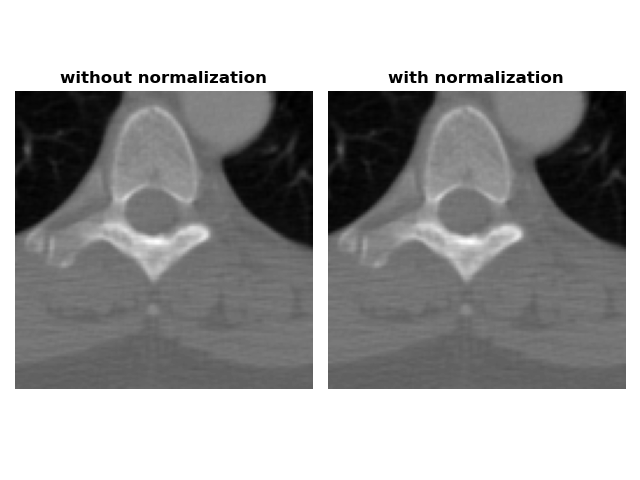

In [6]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

# Plot the grayscale images
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].imshow(im_old, cmap='gray')
axes[0].set_title('without normalization', fontweight ="bold")
axes[1].imshow(im, cmap='gray')
axes[1].set_title('with normalization', fontweight ="bold")
format_and_render_plot()

## Histograms
Histograms display the distribution of values in your image by binning each element by its intensity then measuring the size of each bin.

The area under a histogram is called the cumulative distribution function. It measures the frequency with which a given range of pixel intensities occurs.

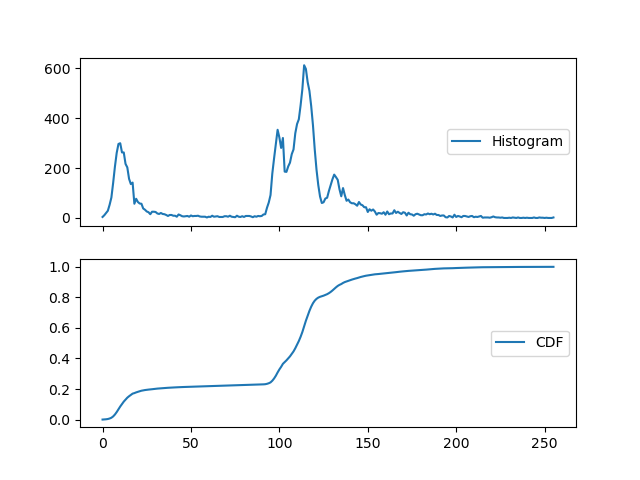

In [7]:
# Create a 256-bin histogram, binned at each possible value
hist = ndi.histogram(im, min=im.min(), max=im.max(), bins=256)

# Create a cumulative distribution function
cdf = hist.cumsum() / hist.sum()

def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.legend(loc='center right')
    plt.show()

# Plot the histogram and CDF
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(hist, label='Histogram')
axes[1].plot(cdf, label='CDF')
#axes[1].set_xticks([0, 1])
#axes[1].set_xticklabels(('0', '1'))
format_and_render_plot()

## Create a Mask
Masks are the primary method for removing or selecting specific parts of an image. They are binary arrays that indicate whether a value should be included in an analysis. Typically, masks are created by applying one or more logical operations to an image.

In this exercise, you use a simple intensity threshold to differentiate between soft tissue and bone.

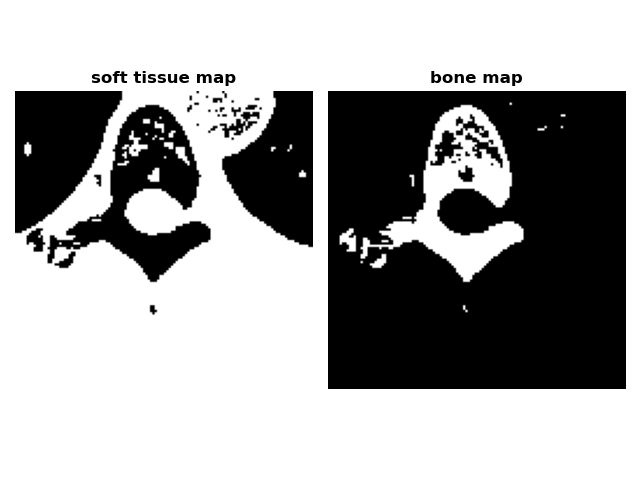

In [8]:
# Create soft tissue (st) and bone masks
# Try different intervals by yourself
mask_st = (im >= 0.2) & (im < 0.52)
mask_bone = im >= 0.53

def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

# Plot the skin (0) and bone (1) masks
fig, axes = plt.subplots(1,2)
axes[0].imshow(mask_st, cmap='gray')
axes[0].set_title('soft tissue map', fontweight ="bold")
axes[1].imshow(mask_bone, cmap='gray')
axes[1].set_title('bone map', fontweight ="bold")
format_and_render_plot()

## Apply a Mask
Although masks are binary, they can be applied to images to filter out pixels where the mask is `False`.

NumPy's `where()` function is a flexible way of applying masks. It takes three arguments:

```Python
np.where(condition, x, y)
```

`condition`, `x` and `y` can be either arrays or single values. This allows you to pass through original image values while setting masked values to 0.

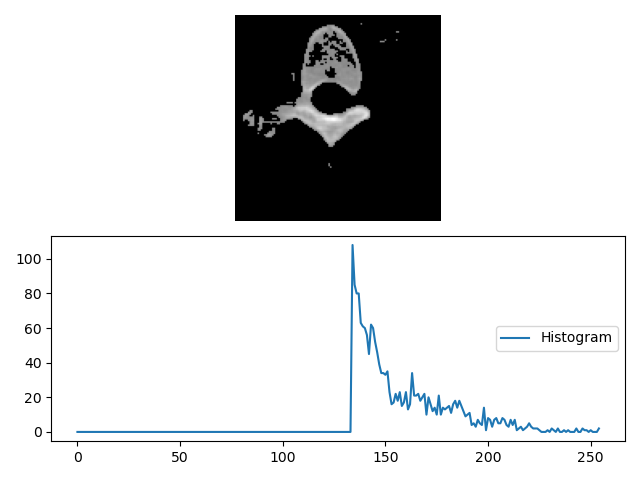

In [9]:
# Screen out non-bone pixels from "im"
im_bone = np.where(mask_bone, im, 0)

# Get the histogram of bone intensities
hist = ndi.histogram(im_bone, min=im_bone.min()+0.01, max=im_bone.max(), bins=255)

def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    fig.axes[0].axis('off')
    fig.axes[1].legend(loc='center right')   
    plt.tight_layout()
    plt.show()

# Plot masked image and histogram
fig, axes = plt.subplots(2,1)
axes[0].imshow(im_bone, cmap='gray')
axes[1].plot(hist, label='Histogram')
format_and_render_plot()

## Tune a Mask
Imperfect masks can be tuned through the addition and subtraction of pixels. SciPy includes several useful methods for accomplishing these ends. These include:

- `binary_dilation`: Add pixels along edges
- `binary_erosion`: Remove pixels along edges
- `binary_opening`: Erode then dilate, "opening" areas near edges
- `binary_closing`: Dilate then erode, "filling in" holes

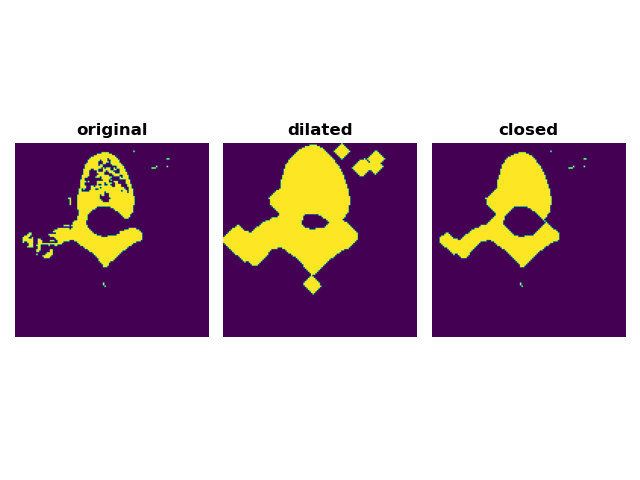

In [10]:
# Create and tune bone mask
mask_dilate = ndi.binary_dilation(mask_bone, iterations=5)
mask_closed = ndi.binary_closing(mask_bone, iterations=5)

def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

# Plot masked images
fig, axes = plt.subplots(1,3)
axes[0].imshow(mask_bone)
axes[0].set_title('original', fontweight ="bold")
axes[1].imshow(mask_dilate)
axes[1].set_title('dilated', fontweight ="bold")
axes[2].imshow(mask_closed)
axes[2].set_title('closed', fontweight ="bold")
format_and_render_plot()

### Exercise 1
Try some other paramters and observe the changes:

In [11]:
# Write your code here






## Filter Convolutions
Filters are an essential tool in image processing. They allow you to transform images based on intensity values surrounding a pixel, rather than globally.

This step is also an important part in the most common DeepLearning models, calles convolutional layer.

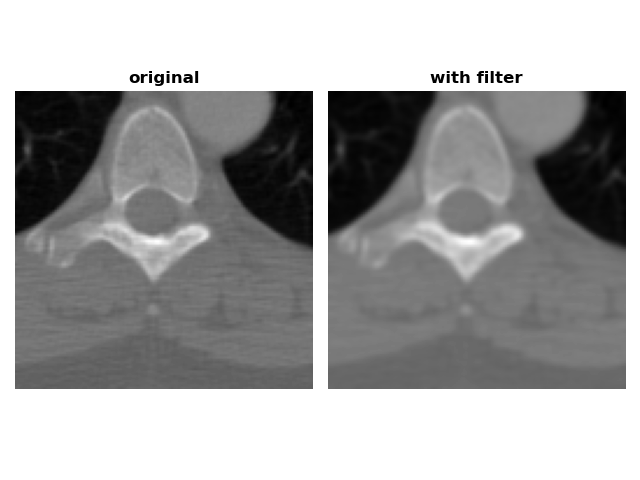

In [12]:
# Set filter weights
weights = [[0.11, 0.11, 0.11],
           [0.11, 0.11, 0.11], 
           [0.11, 0.11, 0.11]]

# Convolve the image with the filter
im_filt = ndi.convolve(im, weights)

# Plot the images
fig, axes = plt.subplots(1,2)
axes[0].imshow(im, cmap='gray')
axes[0].set_title('original', fontweight ="bold")
axes[1].imshow(im_filt, cmap='gray')
axes[1].set_title('with filter', fontweight ="bold")
format_and_render_plot()

## Smoothing
Smoothing can improve the signal-to-noise ratio of your image by blurring out small variations in intensity. The Gaussian filter is excellent for this: it is a circular (or spherical) smoothing kernel that weights nearby pixels higher than distant ones.

The width of the distribution is controlled by the sigma argument, with higher values leading to larger smoothing effects.

<ins>Exercise:</ins> Try different sigmas by yourself!

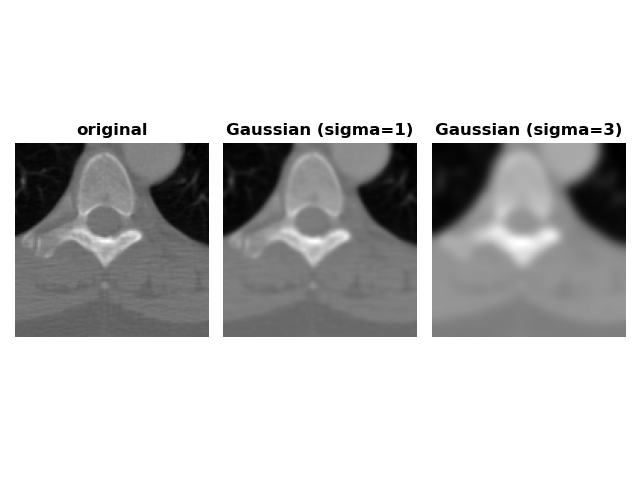

In [13]:
# Smooth "im" with Gaussian filters
# Try different sigmas  by yourself
im_s1 = ndi.gaussian_filter(im, sigma=1)
im_s3 = ndi.gaussian_filter(im, sigma=3)

# Draw bone masks of each image
fig, axes = plt.subplots(1,3)
axes[0].imshow(im, cmap='gray')
axes[0].set_title('original', fontweight ="bold")
axes[1].imshow(im_s1, cmap='gray')
axes[1].set_title('Gaussian (sigma=1)', fontweight ="bold")
axes[2].imshow(im_s3, cmap='gray')
axes[2].set_title('Gaussian (sigma=3)', fontweight ="bold")
format_and_render_plot()

## Detect Edges
Filters can also be used as "detectors." If a part of the image fits the weighting pattern, the returned value will be very high (or very low).

In the case of edge detection, that pattern is a change in intensity along a plane.

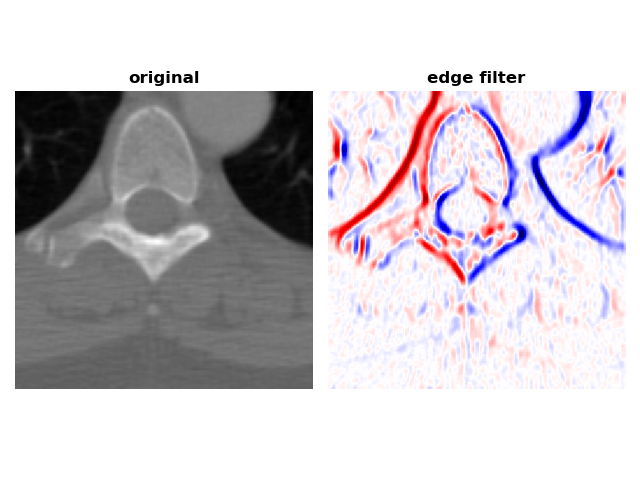

In [14]:
# Set weights to detect vertical edges
weights = [[1, 0, -1],
           [1, 0, -1],
           [1, 0, -1]]

# Convolve "im" with filter weights
edges = ndi.convolve(im, weights)

# Draw the image in color
fig, axes = plt.subplots(1,2)
axes[0].imshow(im, cmap='gray')
axes[0].set_title('original', fontweight ="bold")
axes[1].imshow(edges, cmap='seismic', vmin=-0.8, vmax=0.8)
axes[1].set_title('edge filter', fontweight ="bold")
format_and_render_plot()

### Exercise 2
A filter detecting horizontal edges might look like this:

```Python
weights = [[+1, +1, +1],
           [ 0,  0,  0],
           [-1, -1, -1]]
```

Apply the new filter to the image!

In [15]:
# Write your code here (the solution is below)






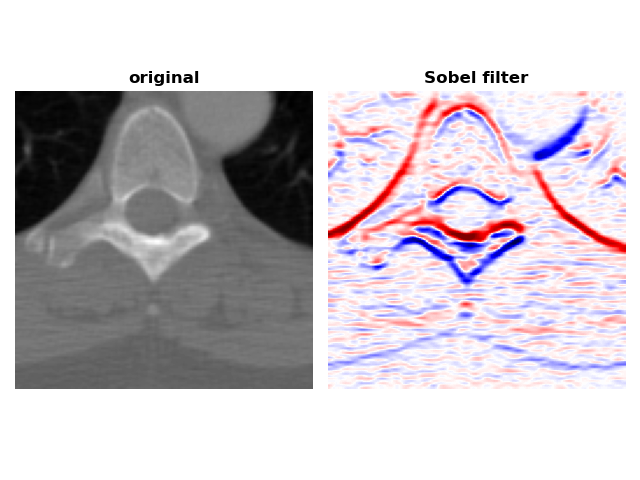

In [16]:
### Solution
# Set weights to detect vertical edges
weights = [[ 1,  1,  1], 
           [ 0,  0,  0],
           [-1, -1, -1]]

# Convolve "im" with filter weights
edges = ndi.convolve(im, weights)

# Draw the image in color
fig, axes = plt.subplots(1,2)
axes[0].imshow(im, cmap='gray')
axes[0].set_title('original', fontweight ="bold")
axes[1].imshow(edges, cmap='seismic', vmin=-0.8, vmax=0.8)
axes[1].set_title('Sobel filter', fontweight ="bold")
format_and_render_plot()